In [1]:
import sys 
import pandas as pd 
import numpy as np 
from tqdm import tqdm
from pyvin import VIN

import seaborn as sns 
import matplotlib.pyplot as plt

from scipy.stats import spearmanr
import spacy 
import re
from nltk.corpus import stopwords as nltk_stopwords

In [2]:
tqdm.pandas()
plt.style.use('seaborn-v0_8-darkgrid')
sys.setrecursionlimit(500000000)
pd.options.mode.chained_assignment = None

## загрузка данных

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [4]:
df_train.columns[~df_train.columns.isin(df_test.columns)] #таргет

Index(['sellingprice'], dtype='object')

In [5]:
df_train.sample(5)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
266981,2010,Honda,Civic,LX,Coupe,automatic,2hgfg1b62ah509129,nc,2.9,165629.0,silver,gray,assets recovered,4700,Mon Mar 02 2015 01:30:00 GMT-0800 (PST)
149922,2005,NaN,NaN,NaN,NaN,NaN,1fmzu73k65ua69658,va,3.2,98339.0,silver,gray,shirlie slack mitsubishi,6500,Thu Jan 22 2015 01:35:00 GMT-0800 (PST)
423368,2012,Infiniti,M,M37x,Sedan,automatic,jn1by1ar7cm390230,nj,2.7,21269.0,—,black,nissan infiniti lt,24000,Wed May 27 2015 02:30:00 GMT-0700 (PDT)
164093,2011,Ford,Transit Connect,Cargo Van XLT,Minivan,automatic,nm0ls7bn7bt042799,md,4.9,116106.0,—,gray,ge fleet services for itself/servicer,8400,Tue Feb 17 2015 01:30:00 GMT-0800 (PST)
30494,2014,Chevrolet,Malibu,LTZ,Sedan,automatic,1g11h5sl9eu124357,il,4.0,11532.0,silver,black,gm remarketing,18500,Thu May 28 2015 04:00:00 GMT-0700 (PDT)


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB


In [7]:
df_train.isna().mean().to_frame()

,0
year,0.000000
make,0.018270
model,0.018451
trim,0.018938
body,0.023608
transmission,0.116894
vin,0.000000
state,0.000000
condition,0.021364
odometer,0.000157


In [8]:
df_test.isna().mean().to_frame()

,0
year,0.000000
make,0.018726
model,0.018890
trim,0.019208
body,0.023569
transmission,0.118219
vin,0.000000
state,0.000000
condition,0.021616
odometer,0.000173


имеется большое количество пропусков в `transmission`. пройдемся по всем колонкам и посмотрит на данные внутри датасета

### year

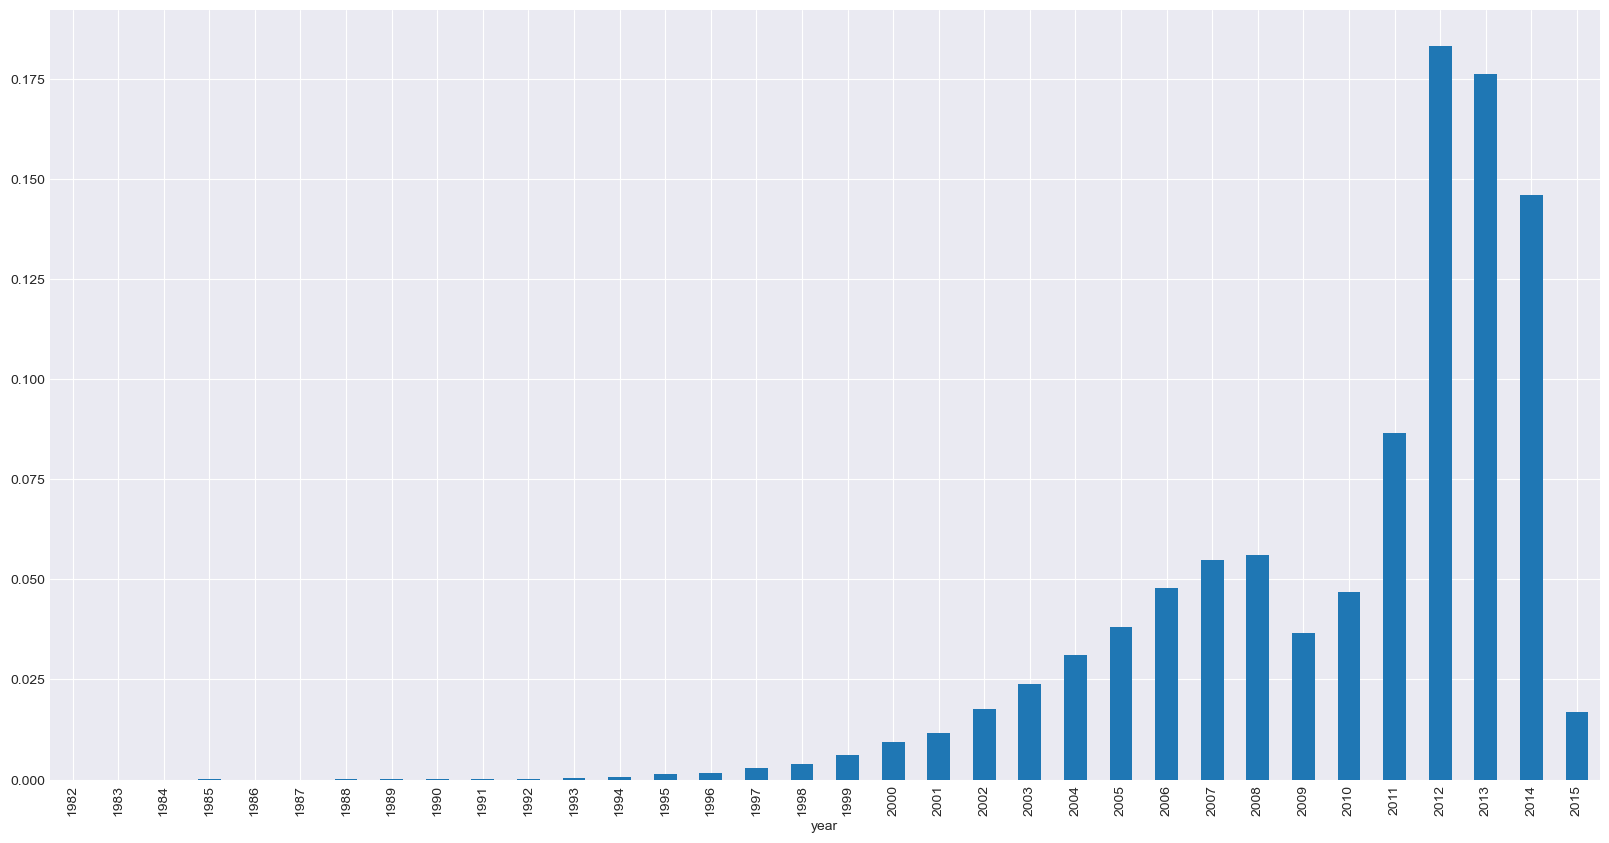

In [9]:
df_train['year'].value_counts(normalize=True).sort_index().plot(kind='bar', figsize=(20,10));

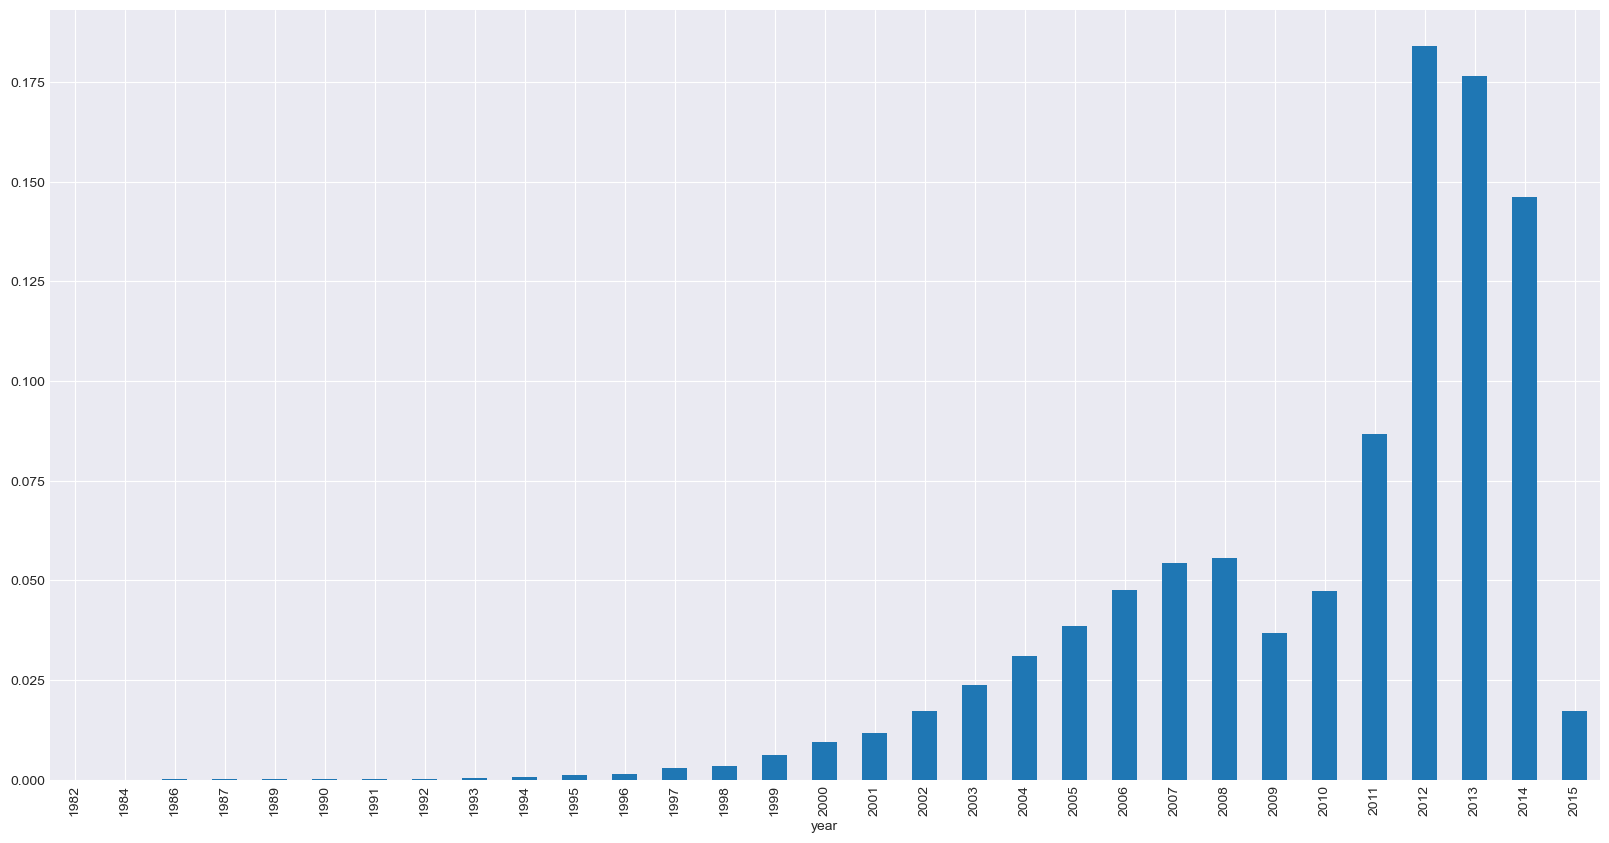

In [10]:
df_test['year'].value_counts(normalize=True).sort_index().plot(kind='bar', figsize=(20,10));

Делаю предположение, что данные собирались на начало 2015 года. Так же есть просадка в 2009 году. Возможно это вызвано кризисом 2007. Что предприятия могли в 2007 сделать план производста меньшим. 

Данный столбец понадобится для генерации нового признака (сколько лет машина на ходу)

Для начала вытащит дату продажи машины

In [11]:
df_train['saledate'].sample() 

212526    Wed Feb 25 2015 01:30:00 GMT-0800 (PST)
Name: saledate, dtype: object

In [12]:
#год продажи автомобиля
df_train['year_2'] = df_train['saledate'].apply(lambda x: x.split(' ')[3]).astype(np.int64)
df_test['year_2'] = df_test['saledate'].apply(lambda x: x.split(' ')[3]).astype(np.int64)

In [13]:
#сколько лет машина была на ходу
df_train['years'] = df_train['year_2'] - df_train['year']
df_test['years'] = df_test['year_2'] - df_test['year']

In [14]:
#удаляем год производства автомобиля, год продажи, и saledate
df_train.drop(columns=['year', 'year_2', 'saledate'], inplace=True)
df_test.drop(columns=['year', 'year_2', 'saledate'], inplace=True)

In [15]:
np.sort(df_train['years'].unique())

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33], dtype=int64)

Можем пронаблюдать значения в -1 год. Когда машина продавалась раньше чем была произведена. 
Было 2 объяснения 1) ошибка 2) закупщики могли покупать напрямую до начала производства     

Было решено создать столбец, в котором будет фиксироваться данный выброс

In [16]:
df_train['test'] = df_train['years'].apply(lambda x: 1 if x<0 else 0)
df_test['test'] = df_test['years'].apply(lambda x: 1 if x<0 else 0)

## make

In [17]:
df_train['make'].nunique()

92

In [18]:
df_test['make'].nunique()

85

In [19]:
df_train['make'].unique()

array(['Ford', 'Nissan', 'HUMMER', 'Lincoln', 'pontiac', 'Hyundai', nan,
       'Buick', 'Chevrolet', 'Honda', 'Acura', 'Cadillac', 'GMC', 'Saab',
       'Dodge', 'Mercedes-Benz', 'Toyota', 'Volkswagen', 'BMW',
       'Infiniti', 'Chrysler', 'Kia', 'Jaguar', 'Subaru', 'Jeep', 'Lexus',
       'mercedes', 'Scion', 'FIAT', 'Suzuki', 'Mazda', 'Volvo', 'Audi',
       'MINI', 'Isuzu', 'Mitsubishi', 'smart', 'Pontiac', 'Porsche',
       'subaru', 'ford', 'Land Rover', 'chrysler', 'Saturn', 'mazda',
       'dodge', 'Ram', 'Oldsmobile', 'hyundai', 'Mercury', 'Bentley',
       'toyota', 'lincoln', 'Fisker', 'nissan', 'chevrolet', 'honda',
       'porsche', 'mitsubishi', 'lexus', 'bmw', 'Maserati', 'acura',
       'jeep', 'mercury', 'Tesla', 'landrover', 'vw', 'cadillac', 'buick',
       'gmc truck', 'land rover', 'volkswagen', 'Rolls-Royce', 'audi',
       'Ferrari', 'suzuki', 'Plymouth', 'oldsmobile', 'Lamborghini',
       'gmc', 'Geo', 'ford truck', 'Aston Martin', 'plymouth', 'Daewoo',
      

у нас есть `Kia` и `kia`, `Mazda`, `mazda`  и т.д.
После заполнения пропусков `будет сделано в конце`, строки будут приведены к нижнему регистру 


### model

In [20]:
df_train.model.nunique()

959

C `model` есть ещё большее количество категорий. Так же будут обработы в конце ноутбука + заполнены пропуски при помощи VIN номера

### trim

In [21]:
df_train['trim'].nunique()

1922

В trim 2% просуков. И большое количество уникальных значений. В ходе обработки было решено его удалить

In [22]:
df_train.drop(columns=['trim'], inplace=True)
df_test.drop(columns=['trim'], inplace=True)

### body 

Данный столбец был приведён к нижнему регистру, пропуски были заполнены как `unknown`

In [23]:
def lower(x):
    try:
        return x.lower()
    except:
        return None
    
df_train['body'] = df_train['body'].apply(lower)
df_test['body'] = df_test['body'].apply(lower)

In [24]:
df_train['body'].fillna('unknown', inplace=True)
df_test['body'].fillna('unknown', inplace=True)

In [25]:
df_train['body'].value_counts(normalize=True).head()

body
sedan        0.433542
suv          0.256776
hatchback    0.047054
minivan      0.045689
coupe        0.031565
Name: proportion, dtype: float64

В 43% случаях покупается `sedan` 

### transmission

In [26]:
df_train['transmission'].value_counts()

transmission
automatic    375061
manual        13714
Name: count, dtype: int64

Данные пропуски было решено заполнить по частоте

In [27]:
df_train['transmission'].fillna('automatic', inplace=True)
df_test['transmission'].fillna('automatic', inplace=True)

### state

In [28]:
df_train['state'].unique()

array(['md', 'mo', 'nj', 'tx', 'mi', 'nc', 'fl', 'oh', 'ca', 'az', 'ga',
       'tn', 'in', 'pa', 'va', 'wi', 'co', 'ny', 'il', 'nv', 'mn', 'wa',
       'sc', 'la', 'ne', 'ok', 'or', 'on', 'ma', 'ab', 'pr', 'hi', 'ut',
       'qc', 'ms', 'nm', 'ns', 'al'], dtype=object)

In [29]:
df_train['state'].fillna('unknown', inplace=True)
df_test['state'].fillna('unknown', inplace=True)

###  condition

Вместо того, что бы заполнять пропуски по моде, было решено, что оценка коррелирует со сроком эксплуатации автомобиля. Потому мы можем разбить по группам

In [30]:
df_train.loc[df_train['condition'].notna(), ['condition', 'years']].corr()

,condition,years
condition,1.000000,-0.551399
years,-0.551399,1.000000


In [31]:
df_train['condition'].fillna(df_train.groupby('years')['condition'].transform('mean'), inplace=True) 
df_test['condition'].fillna(df_test.groupby('years')['condition'].transform('mean'), inplace=True)

### odometer

Для odometer данный способ заполнения должен показать себя ещё лучше

In [32]:
df_train.loc[df_train['odometer'].notna(), ['odometer', 'years']].corr()

,odometer,years
odometer,1.000000,0.772479
years,0.772479,1.000000


In [33]:
df_train['odometer'].fillna(df_train.groupby('years')['odometer'].transform('mean'), inplace=True)
df_test['odometer'].fillna(df_test.groupby('years')['odometer'].transform('mean'), inplace=True)

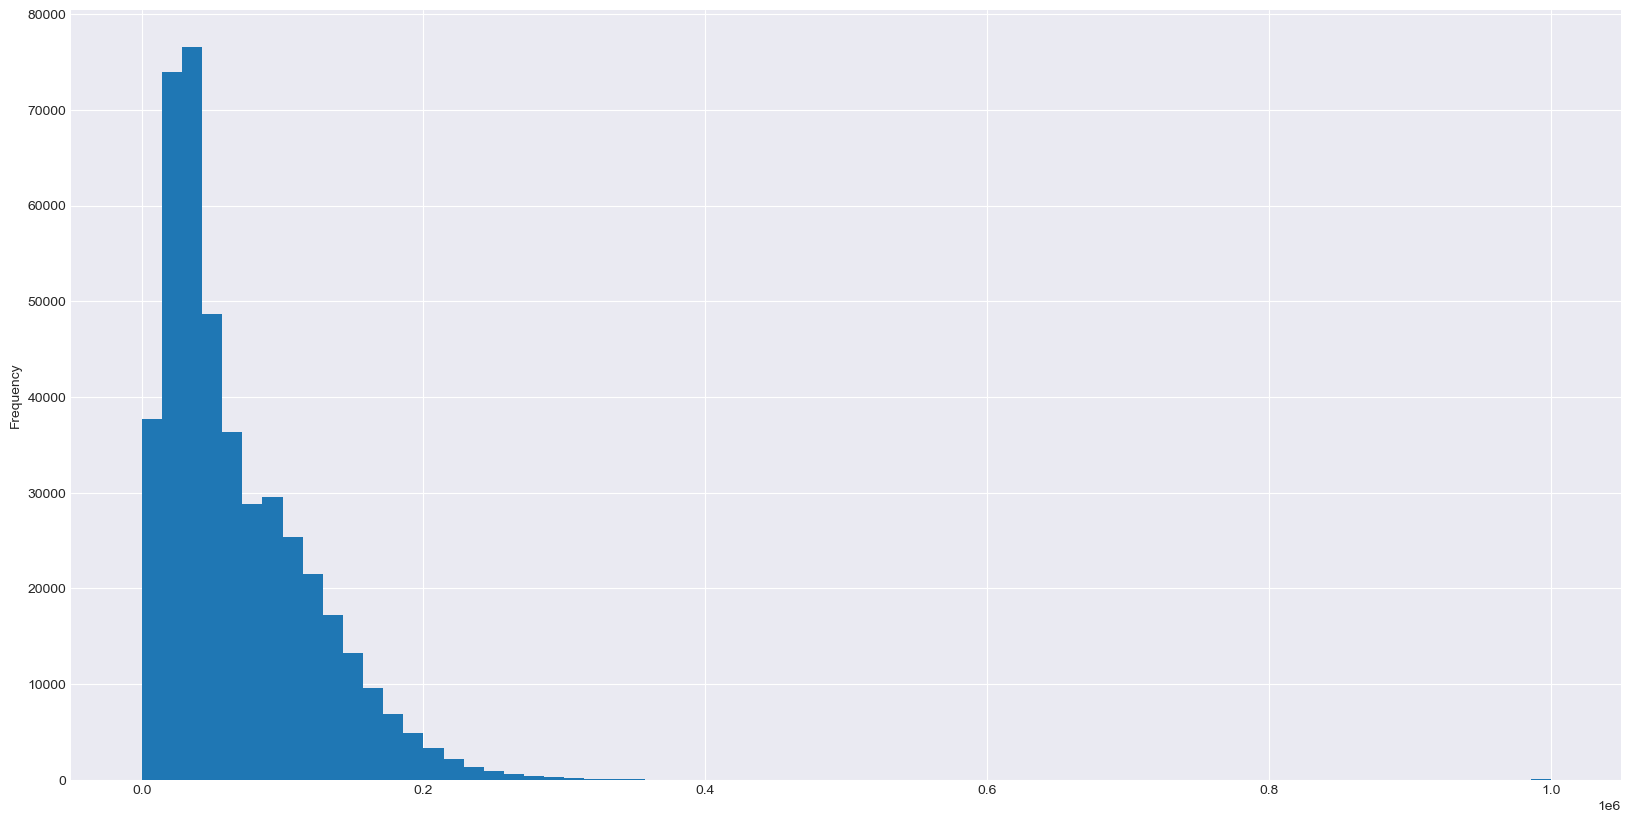

In [34]:
df_train['odometer'].plot(kind='hist', bins=70, figsize=(20,10));

У нас медленно убывающий хвост. Потому было предложенно добавить признак от логарифма

In [35]:
df_train['odometer_2'] = df_train['odometer'].apply(lambda x: np.log(x))
df_test['odometer_2'] = df_test['odometer'].apply(lambda x: np.log(x))

### color и interior 

В данных столбцах есть уникальное значение = `-`. Было сделано, что так заполнялись пропуски в данных столбцах.

In [36]:
df_train['interior'].fillna('-', inplace=True)
df_test['interior'].fillna('-', inplace=True)
df_train['color'].fillna('-', inplace=True)
df_test['color'].fillna('-', inplace=True)

### make и body 

данные столбцы были востановленны при помощи vin номера

In [37]:
df_train['vin'] = df_train['vin'].apply(lambda x: x.upper())
df_test['vin'] = df_test['vin'].apply(lambda x: x.upper())

In [38]:
def model(x):
    try:
        return VIN(x).Model
    except:
        return None
    
    
def make(x):
    try:
        return VIN(x).Make
    except:
        return None

In [39]:
# пропуски в model
df_test.loc[df_test['model'].isna(), 'model'] = df_test.loc[df_test['model'].isna(), 'vin'].progress_apply(model)

100%|██████████████████████████████████████████████████████████████████████████████| 2079/2079 [10:35<00:00,  3.27it/s]


In [40]:
# пропуски в make
df_test.loc[df_test['make'].isna(), 'make'] = df_test.loc[df_test['make'].isna(), 'vin'].progress_apply(make)

100%|██████████████████████████████████████████████████████████████████████████████| 2061/2061 [10:31<00:00,  3.27it/s]


In [41]:
# обработка make
df_test['make'] = df_test['make'].apply(lambda x: x.capitalize())

In [42]:
# тренировочная выборка
df_train.loc[df_train['model'].isna(), 'model'] = df_train.loc[df_train['model'].isna(), 'vin'].progress_apply(model)

100%|██████████████████████████████████████████████████████████████████████████████| 8123/8123 [43:42<00:00,  3.10it/s]


In [43]:
df_train.loc[df_train['make'].isna(), 'make'] = df_train.loc[df_train['make'].isna(), 'vin'].progress_apply(make)

100%|██████████████████████████████████████████████████████████████████████████████| 8043/8043 [40:50<00:00,  3.28it/s]


In [44]:
# было решено удалить несколько строк, в которых не смогли вытащить из VIN информацию
df_train = df_train[~df_train['make'].isna()].reset_index(drop=True)

In [45]:
df_train['make'] = df_train['make'].apply(lambda x: x.capitalize())

In [46]:
df_train.drop(columns=['vin'], inplace=True)
df_test.drop(columns=['vin'], inplace=True)

### sellingprice

In [47]:
nlp = spacy.load('en_core_web_sm', disable = ['parser', 'ner'])

def text_token(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = ' '.join([word.lower() for word in text.split()])
    text = ' '.join([token.lemma_ for token in nlp(text)])
    return text

In [48]:
df_train['lema'] = df_train['seller'].progress_apply(text_token)

100%|█████████████████████████████████████████████████████████████████████████| 440233/440233 [25:25<00:00, 288.49it/s]


In [49]:
df_test['lema'] = df_test['seller'].progress_apply(text_token)

100%|█████████████████████████████████████████████████████████████████████████| 110058/110058 [05:27<00:00, 335.74it/s]


In [50]:
df_train.drop(columns=['seller'], inplace=True)
df_test.drop(columns=['seller'], inplace=True)

In [51]:
df_test.to_csv('test_pr.csv', index=False)
df_train.to_csv('train_pr.csv', index=False)

In [52]:
df_test.head()

,make,model,body,transmission,state,condition,odometer,color,interior,years,test,odometer_2,lema
0,Cadillac,CTS,sedan,automatic,ca,2.7,116970.0,silver,black,10,0,11.669673,lexus of stevens creek
1,Gmc,Savana Cargo,van,automatic,pa,4.4,6286.0,white,gray,1,0,8.746080,u haul
2,Nissan,Murano,suv,automatic,oh,4.6,11831.0,gray,black,2,0,9.378478,nissan infiniti lt
3,Chevrolet,Impala,sedan,automatic,fl,2.3,57105.0,silver,black,2,0,10.952647,onemain rem auto club of miami inc dba north dad
4,Nissan,Titan,crew cab,automatic,tn,2.9,31083.0,black,black,2,0,10.344416,nissan north america inc
